## Deep Learning-6, Programming exercise.
#### Done by :
#### Aysha Athar Siddiqui
#### Andrzej Reinke
#### Chan Chun Peng
#### Ramaswamy Venkatachalam
#### Yash Goel

In [1]:
import pickle
from pathlib import Path
from time import time
from collections import namedtuple
from itertools import repeat
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from torchsummary import summary

In [2]:
print('Device at work: ', device)

Device at work:  cuda:0


In [3]:
class TrainProgressBar:
    def __init__(self, num_runs, num_epochs, num_batches):
        self._runs_bar = tqdm(total=num_runs, desc="runs") if num_runs > 1 else None
        self._epoch_bar = tqdm(total=num_epochs, desc="epochs")
        self._batch_bar = tqdm(total=num_batches, desc="batches")
        
    @staticmethod
    def _decorate_iterator(it, pbar):
        try:
            pbar.reset(total=len(it))
        except TypeError:
            pbar.reset()
        
        for item in it:
            yield item
            pbar.update(1)
            
    def runs(self, iterator):
        if self._runs_bar:
            yield from TrainProgressBar._decorate_iterator(iterator, self._runs_bar)
        else:
            yield from iterator
        
    def epochs(self, iterator):
        yield from TrainProgressBar._decorate_iterator(iterator, self._epoch_bar)
        
    def batches(self, iterator):
        yield from TrainProgressBar._decorate_iterator(iterator, self._batch_bar)
        
    def write(self, text):
        self._batch_bar.write(text)
        
    def close(self):
        if self._runs_bar:
            self._runs_bar.close()
        self._epoch_bar.close()
        self._batch_bar.close()
        
    def __enter__(self):
        return self
    
    def __exit__(self, *exc):
        self.close()

In [4]:

class CIFAR10Dataset:
    def __init__(self, dataset='train', path='.', transform=None):
        path = Path(path)
        if dataset == 'train':
            batches = [self.load_batch(p) for p in path.glob('data_batch_*')]
            self.images = torch.cat([b for b, _ in batches])
            self.labels = torch.cat([b for _, b in batches])
        elif dataset == 'test':
            self.images, self.labels = self.load_batch(path / 'test_batch')
            
        # normalize
        self.images = self.images.float()
        self.labels = self.labels.long()
        
        std, mean = torch.std_mean(self.images, dim=0)
        self.images = (self.images - mean) / std
        
        self.transform = transform
        
        assert len(self.images) == len(self.labels)
    
    def load_batch(self, path):
        with open(path, 'rb') as file:
            data_dict = pickle.load(file, encoding='bytes')
        images = data_dict[b'data'].reshape((-1, 32, 32, 3), order='F').swapaxes(1,3)
        images = torch.from_numpy(images)
        labels = torch.Tensor(data_dict[b'labels'])
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]
        if(self.transform):
            x = self.transform(x)
        return x,y

In [5]:
class CUDADataLoader(DataLoader):
    def __iter__(self):
        for images, labels in super(CUDADataLoader, self).__iter__():
            yield [images.to(device), labels.to(device)]

In [6]:
PATH = "../dataset/cifar/cifar-10-batches-py/"

train_dataset = CIFAR10Dataset('train',PATH)
test_dataset = CIFAR10Dataset('test',PATH)

train_dataloader = CUDADataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = CUDADataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)


In [7]:
def predictions_to_hits(predictions, labels):
    return predictions.argmax(dim=1).eq(labels).count_nonzero()

def train(model, optimizer, train_dataloader, test_dataloader=None,
          loss_fn=None, reg_fn=None, num_epochs=25, pbar=None):
    
    # init outputs and progressbar
    
    losses = torch.zeros(num_epochs)
    train_accuracies = torch.zeros(num_epochs)
    test_accuracies = torch.zeros(num_epochs)
    
    for epoch in pbar.epochs(range(num_epochs)):
        
        # init variables
        
        epoch_losses = torch.zeros(len(train_dataloader)).to("cuda:0")
        hits = torch.zeros(1).to("cuda:0")
        total = torch.zeros(1).to("cuda:0")
        
        # train model
        
        model.train(True)
        
        for i, (images, labels) in enumerate(pbar.batches(train_dataloader)):
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            
            if(reg_fn):
                loss += reg_fn()
            
            loss.backward()
            optimizer.step()
            
            epoch_losses[i] = loss
            hits += predictions_to_hits(predictions, labels)
            total += len(images)
        
        losses[epoch] = torch.mean(epoch_losses)
        train_accuracies[epoch] = hits / total
        
        # get test accuracy
        
        model.train(False)
        
        if test_dataloader is not None:
            hits[:] = total[:] = 0
            for images, labels in pbar.batches(test_dataloader):
                predictions = model(images)
                hits += predictions_to_hits(predictions, labels)
                total += len(images)
            
        test_accuracies[epoch] = hits / total
        
        # update pbar
        
        pbar.write(f"[{epoch+1:>2}/{num_epochs}] "
                   f"train_accuracy: {train_accuracies[epoch]:.4f}, "
                   f"test_accuracy: {test_accuracies[epoch]:.4f}, "
                   f"loss: {losses[epoch]:.4f}")
    
    return tuple(a.detach().numpy() for a in (losses, train_accuracies, test_accuracies))

In [8]:
Results = namedtuple("Results", "losses train_accuracies test_accuracies")

def plot_results(names, results):
    _, axs = plt.subplots(1,2,figsize=(14,7))
    
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')
    
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('accuracy')
    
    for name, result in zip(names, results):
        a, *_ = axs[0].plot(result.losses, label=name)
        axs[1].plot(result.test_accuracies, label=name, color=a.get_color())
        #axs[1].plot(result.train_accuracies, label=name, color=a.get_color(), linestyle='dashed')

    axs[0].legend()
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

# Baseline Model
MLP with batchnorm

In [9]:
def make_bn_model():
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, 512),
        nn.BatchNorm1d(512,affine=False,momentum=0.1),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512,affine=False,momentum=0.1),
        nn.ReLU(),
        nn.Linear(512, 10),
        nn.BatchNorm1d(10,affine=False,momentum=0.1),
    ).to(device)

def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))

In [10]:
results = dict()

In [11]:
## batch norm model - Baseline Model
baseline = make_bn_model()
optimizer = make_optimizer(baseline)

with TrainProgressBar(1, 25, 782) as pbar:
    results["baseline"] = Results(*train(baseline, optimizer, train_dataloader, test_dataloader,
                                         loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

[ 1/25] train_accuracy: 0.4287, test_accuracy: 0.4961, loss: 1.6366
[ 2/25] train_accuracy: 0.5075, test_accuracy: 0.5199, loss: 1.4565
[ 3/25] train_accuracy: 0.5443, test_accuracy: 0.5392, loss: 1.3740
[ 4/25] train_accuracy: 0.5765, test_accuracy: 0.5465, loss: 1.3091
[ 5/25] train_accuracy: 0.6054, test_accuracy: 0.5491, loss: 1.2530
[ 6/25] train_accuracy: 0.6260, test_accuracy: 0.5527, loss: 1.2099
[ 7/25] train_accuracy: 0.6503, test_accuracy: 0.5640, loss: 1.1647
[ 8/25] train_accuracy: 0.6700, test_accuracy: 0.5683, loss: 1.1238
[ 9/25] train_accuracy: 0.6925, test_accuracy: 0.5627, loss: 1.0854
[10/25] train_accuracy: 0.7112, test_accuracy: 0.5718, loss: 1.0494
[11/25] train_accuracy: 0.7339, test_accuracy: 0.5674, loss: 1.0109
[12/25] train_accuracy: 0.7530, test_accuracy: 0.5602, loss: 0.9775
[13/25] train_accuracy: 0.7702, test_accuracy: 0.5599, loss: 0.9470
[14/25] train_accuracy: 0.7847, test_accuracy: 0.5749, loss: 0.9201
[15/25] train_accuracy: 0.8017, test_accuracy: 0

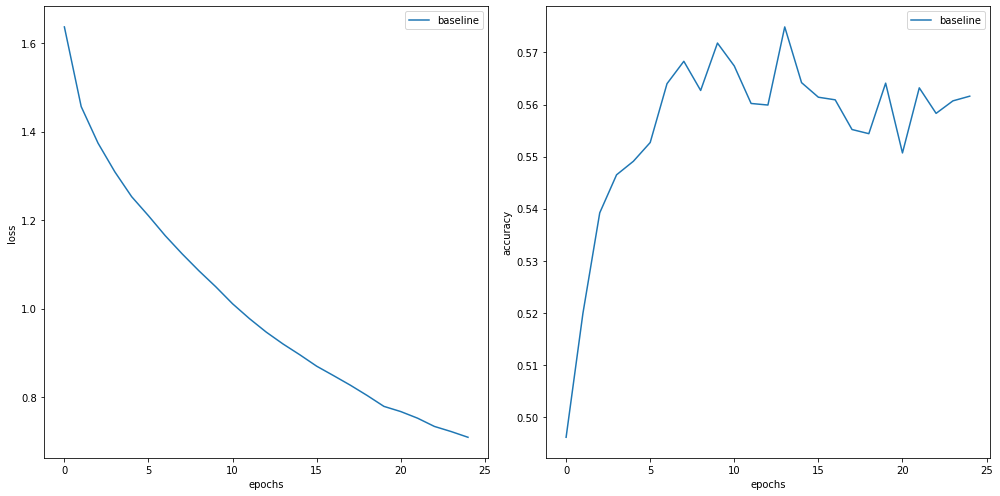

In [12]:
plot_results(['baseline'], [results['baseline']])


# CNN Model

In [13]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3,padding=(1,1))        
        self.conv3 = nn.Conv2d(32, 64, 3,padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3,padding=(1,1))
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1,4096)
        return self.flatten(x)

In [14]:
## cnn model training
cnn_model = CNNModel().cuda()
optimizer = make_optimizer(cnn_model)

with TrainProgressBar(1, 25, 782) as pbar:
    results["cnn_model"] = Results(*train(cnn_model, optimizer, train_dataloader, test_dataloader,
                                         loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

[ 1/25] train_accuracy: 0.4798, test_accuracy: 0.5788, loss: 1.4565
[ 2/25] train_accuracy: 0.6327, test_accuracy: 0.6718, loss: 1.0475
[ 3/25] train_accuracy: 0.7023, test_accuracy: 0.7134, loss: 0.8560
[ 4/25] train_accuracy: 0.7446, test_accuracy: 0.7237, loss: 0.7374
[ 5/25] train_accuracy: 0.7706, test_accuracy: 0.7482, loss: 0.6618
[ 6/25] train_accuracy: 0.7934, test_accuracy: 0.7542, loss: 0.5975
[ 7/25] train_accuracy: 0.8130, test_accuracy: 0.7579, loss: 0.5401
[ 8/25] train_accuracy: 0.8330, test_accuracy: 0.7649, loss: 0.4891
[ 9/25] train_accuracy: 0.8449, test_accuracy: 0.7636, loss: 0.4490
[10/25] train_accuracy: 0.8580, test_accuracy: 0.7631, loss: 0.4104
[11/25] train_accuracy: 0.8705, test_accuracy: 0.7635, loss: 0.3713
[12/25] train_accuracy: 0.8834, test_accuracy: 0.7606, loss: 0.3360
[13/25] train_accuracy: 0.8948, test_accuracy: 0.7592, loss: 0.3022
[14/25] train_accuracy: 0.9062, test_accuracy: 0.7629, loss: 0.2703
[15/25] train_accuracy: 0.9158, test_accuracy: 0

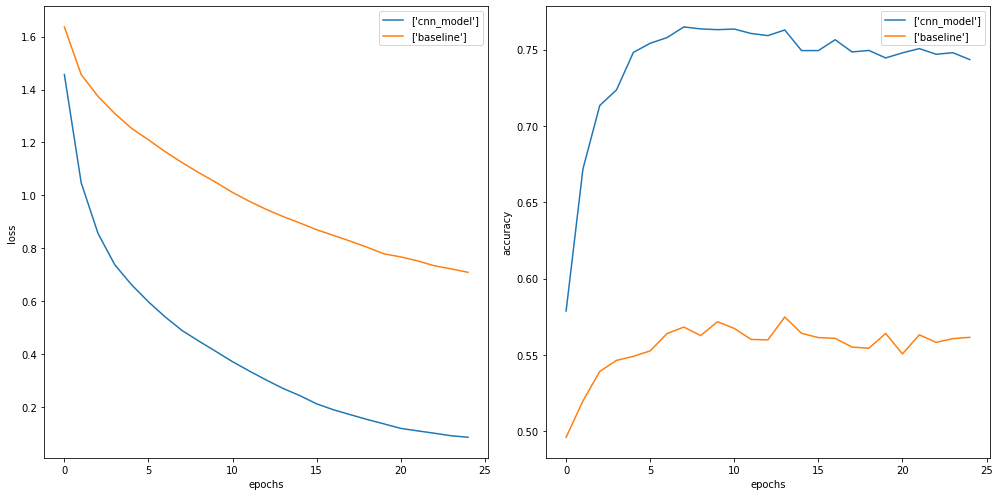

In [15]:
plot_results([['cnn_model'],['baseline']], [results['cnn_model'],results['baseline']])

### CNN better 
because through the various convolutional layers it looks at image patches for getting better features and also offers better dimension reductionality leading to efficient training

# Transfromation
Random Crop of size 32 randomly diminishes the images and the horizontal flip makes it robust to feature and hence making it more invariant to orientation.

In [16]:
### define transformations
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
])

train_dataset_transform = CIFAR10Dataset('train',PATH,transform=transform_train)
train_dataloader_transform = CUDADataLoader(train_dataset_transform, batch_size=64, shuffle=True, pin_memory=True)

In [17]:
## cnn model with tranformations
cnn_model_trans = CNNModel().cuda()
optimizer = make_optimizer(cnn_model_trans)

with TrainProgressBar(1, 25, 782) as pbar:
    results["cnn_model_trans"] = Results(*train(cnn_model_trans, optimizer, train_dataloader_transform, test_dataloader,
                                         loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

[ 1/25] train_accuracy: 0.4192, test_accuracy: 0.5558, loss: 1.6038
[ 2/25] train_accuracy: 0.5533, test_accuracy: 0.6145, loss: 1.2585
[ 3/25] train_accuracy: 0.6161, test_accuracy: 0.6699, loss: 1.0941
[ 4/25] train_accuracy: 0.6534, test_accuracy: 0.6972, loss: 0.9914
[ 5/25] train_accuracy: 0.6793, test_accuracy: 0.7247, loss: 0.9170
[ 6/25] train_accuracy: 0.7020, test_accuracy: 0.7413, loss: 0.8606
[ 7/25] train_accuracy: 0.7220, test_accuracy: 0.7575, loss: 0.8106
[ 8/25] train_accuracy: 0.7337, test_accuracy: 0.7635, loss: 0.7677
[ 9/25] train_accuracy: 0.7419, test_accuracy: 0.7552, loss: 0.7462
[10/25] train_accuracy: 0.7521, test_accuracy: 0.7722, loss: 0.7189
[11/25] train_accuracy: 0.7617, test_accuracy: 0.7883, loss: 0.6868
[12/25] train_accuracy: 0.7696, test_accuracy: 0.7789, loss: 0.6691
[13/25] train_accuracy: 0.7750, test_accuracy: 0.7955, loss: 0.6570
[14/25] train_accuracy: 0.7802, test_accuracy: 0.7950, loss: 0.6350
[15/25] train_accuracy: 0.7846, test_accuracy: 0

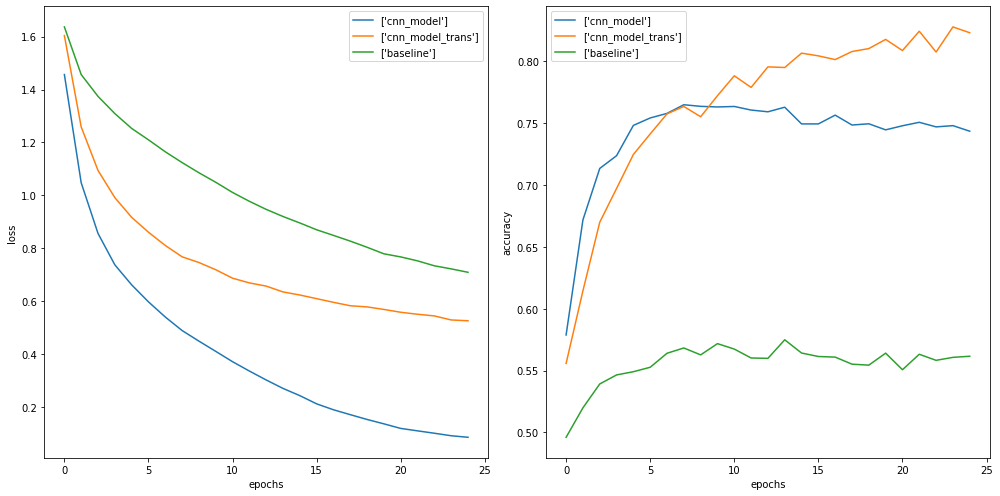

In [18]:
plot_results([['cnn_model'],['cnn_model_trans'],['baseline']], 
             [results['cnn_model'],results['cnn_model_trans'],results['baseline']])

# With Regularization
Batchnorm2d has been used after each convolutional layer

In [19]:
class CNNModelReg(nn.Module):
    def __init__(self):
        super(CNNModelReg, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=(1,1))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3,padding=(1,1))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3,padding=(1,1))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3,padding=(1,1))
        self.bn4 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool(x)
        x = x.view(-1,4096)
        return self.flatten(x)

In [20]:
## cnn model with tranformations and regularization
cnn_model_trans_reg = CNNModelReg().cuda()
optimizer = make_optimizer(cnn_model_trans_reg)

with TrainProgressBar(1, 25, 782) as pbar:
    results["cnn_model_trans_reg"] = Results(*train(cnn_model_trans_reg, optimizer, train_dataloader_transform, test_dataloader,
                                         loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

[ 1/25] train_accuracy: 0.5101, test_accuracy: 0.6525, loss: 1.3911
[ 2/25] train_accuracy: 0.6401, test_accuracy: 0.7107, loss: 1.0428
[ 3/25] train_accuracy: 0.6853, test_accuracy: 0.7277, loss: 0.9169
[ 4/25] train_accuracy: 0.7115, test_accuracy: 0.7476, loss: 0.8361
[ 5/25] train_accuracy: 0.7304, test_accuracy: 0.7613, loss: 0.7868
[ 6/25] train_accuracy: 0.7460, test_accuracy: 0.7769, loss: 0.7416
[ 7/25] train_accuracy: 0.7613, test_accuracy: 0.7837, loss: 0.7005
[ 8/25] train_accuracy: 0.7681, test_accuracy: 0.7936, loss: 0.6793
[ 9/25] train_accuracy: 0.7796, test_accuracy: 0.7945, loss: 0.6421
[10/25] train_accuracy: 0.7846, test_accuracy: 0.8093, loss: 0.6261
[11/25] train_accuracy: 0.7907, test_accuracy: 0.8093, loss: 0.6058
[12/25] train_accuracy: 0.7998, test_accuracy: 0.8105, loss: 0.5841
[13/25] train_accuracy: 0.8073, test_accuracy: 0.8173, loss: 0.5680
[14/25] train_accuracy: 0.8094, test_accuracy: 0.8236, loss: 0.5594
[15/25] train_accuracy: 0.8151, test_accuracy: 0

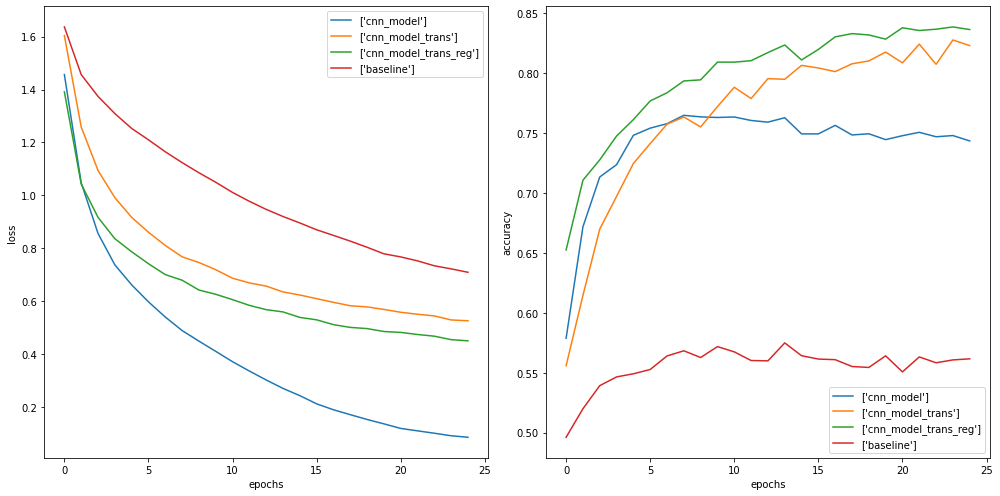

In [21]:
plot_results([['cnn_model'],['cnn_model_trans'],['cnn_model_trans_reg'],['baseline']], 
             [results['cnn_model'],results['cnn_model_trans'],results['cnn_model_trans_reg'],results['baseline']])

# Visualizing filter respones

In [22]:
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().reshape(3,32,32).transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

This dataloader gives a mean subtracted image that is why it looks a little weird.

torch.Size([1, 3, 32, 32])


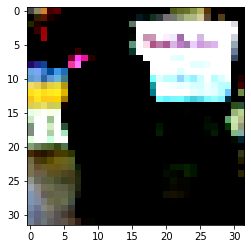

In [23]:
vis_dataloader = CUDADataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
img, label = next(iter(vis_dataloader))
print(img.shape)
imshow(img)

In [24]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def plot_activation(act_,rows=8,cols=4):
    act = act_.squeeze().cpu()
    fig=plt.figure(figsize=(10, 10))
    for i in range(1, cols*rows +1):
        img = act[i-1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
    plt.show()

In [25]:
cnn_model_trans_reg.conv1.register_forward_hook(get_activation('conv1'))
cnn_model_trans_reg.conv2.register_forward_hook(get_activation('conv2'))
cnn_model_trans_reg.conv3.register_forward_hook(get_activation('conv3'))
cnn_model_trans_reg.conv4.register_forward_hook(get_activation('conv4'))

output = cnn_model_trans_reg(img)

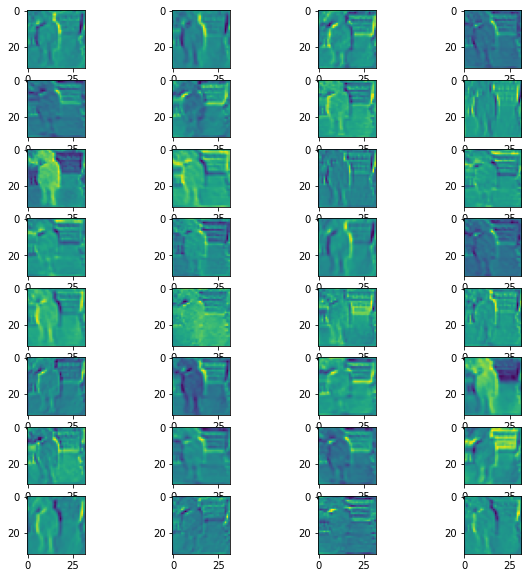

In [26]:
plot_activation(activation['conv1'])

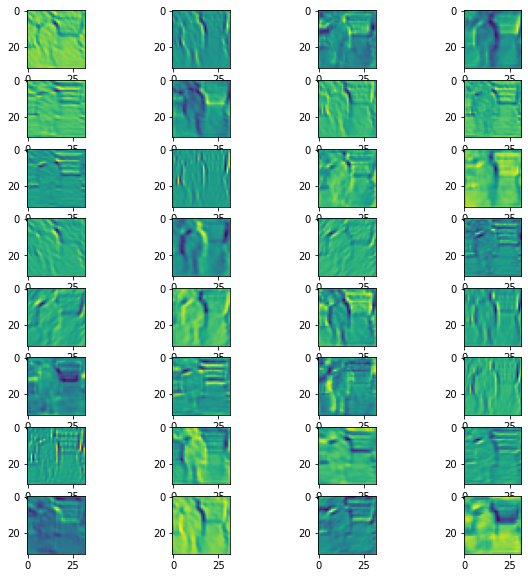

In [27]:
plot_activation(activation['conv2'])

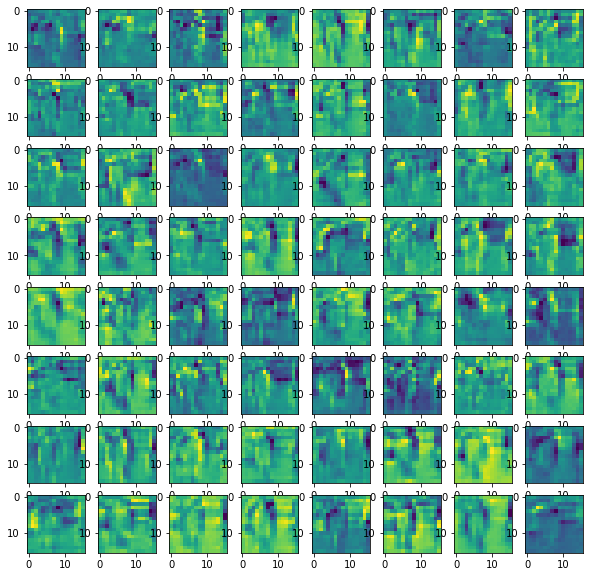

In [28]:
plot_activation(activation['conv3'],cols=8)

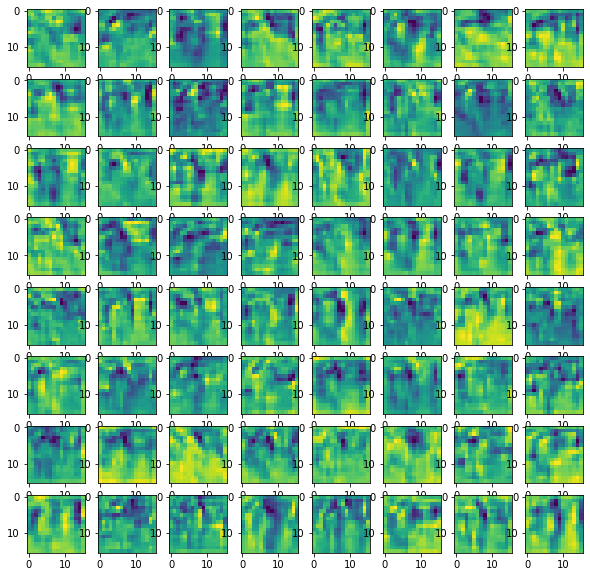

In [29]:
plot_activation(activation['conv4'],cols=8)